## 作業
請詳細閱讀 https://github.com/qqwweee/keras-yolo3 的 readme ，按照 readme 的說明嘗試修改程式碼範例，學會使用 tiny YOLOv3 來做檢測，並且計算其平均 fps 以及觀察其檢測結果。


In [1]:
# 查看 GPU
!nvidia-smi 

Sun Aug 16 22:50:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 連結 Google Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

# 下載 YOLO V3 程式碼

In [3]:
import os
import subprocess

# 指定工作目錄
os.chdir( '/content/gdrive/My Drive' )

# 下載程式碼
if not os.path.exists( "keras-yolo3" ):
    print( "YOLO V3 code doesn't exist, downloading..." )
    !git clone https://github.com/qqwweee/keras-yolo3
    os.chdir('/content/gdrive/My Drive/keras-yolo3') 
else:  
    print( "YOLO V3 code exists." )
    os.chdir('/content/gdrive/My Drive/keras-yolo3')

YOLO V3 code exists.


下載模型預訓練好的權重

In [4]:
if not os.path.exists( 'model_data/yolo.h5' ):
  # 下載 Yolo V3 的網路權重，並且把權重轉換為 Keras 能夠讀取的格式
  print( "Model doesn't exist, downloading..." )
  os.system( "wget https://pjreddie.com/media/files/yolov3.weights" )
  print( 'Converting yolov3.weights to yolo.h5...' )
  os.system( "python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5" )
else:
  print( 'Model exist.' )

Model exist.


# 匯入套件

In [5]:
# 確保 Colob 中使用的 TensorFlow 是 1.x 版本而不是 TensorFlow 2
try:
    %tensorflow_version 1.x 
except Exception:
    pass

import tensorflow as tf 
import keras
print( 'TensorFlow 的版本:', tf.__version__ )

TensorFlow 1.x selected.
TensorFlow 的版本: 1.15.2


Using TensorFlow backend.


In [6]:
# 將 yolo.py 所需要的套件載入
import colorsys
import os
import time
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

# 下載範例圖片

In [7]:
os.system( 'wget https://github.com/pjreddie/darknet/blob/master/data/dog.jpg?raw=true -O dog.jpg' )
os.system( 'wget https://github.com/pjreddie/darknet/blob/master/data/horses.jpg?raw=true -O horses.jpg' )

0

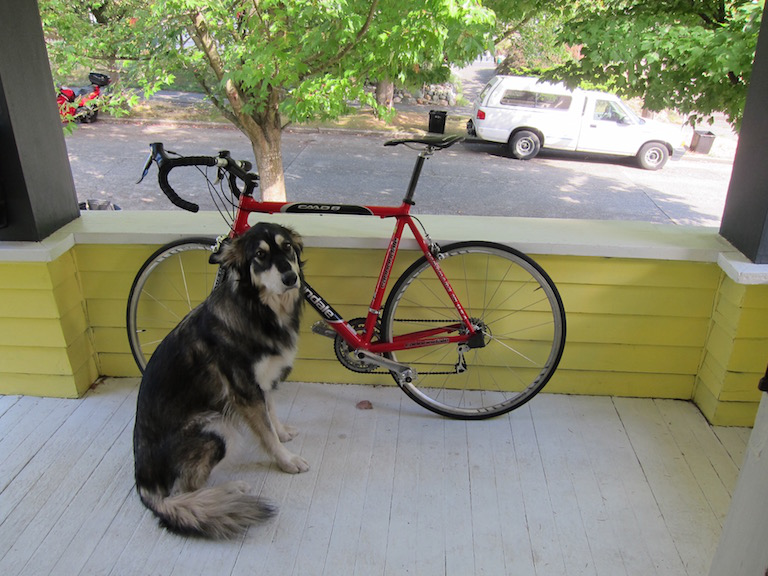

In [8]:
# 讀取並顯示範例圖片
image = Image.open( 'dog.jpg' ) 
image

# YOLO V3 演算法

In [9]:
# 定義 YOLO class
class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolo.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes
    
    # 更改 detect_image 使得其回傳需要的信息
    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        # return out_boxes, out_scores, out_classes
        return image

    def close_session(self):
        self.sess.close()

    # 單純 inference 的 method
    def pure_detect_image(self, image):
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        # print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        return image, out_boxes, out_scores, out_classes

# YOLO V3 物件偵測

In [10]:
yolo = YOLO() # 初始化 YOLO class

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
model_data/yolo.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(416, 416, 3)
Found 3 boxes for img
dog 0.99 (128, 224) (314, 537)
truck 0.91 (475, 85) (689, 170)
bicycle 0.99 (162, 119) (565, 441)
0.059389636000105384


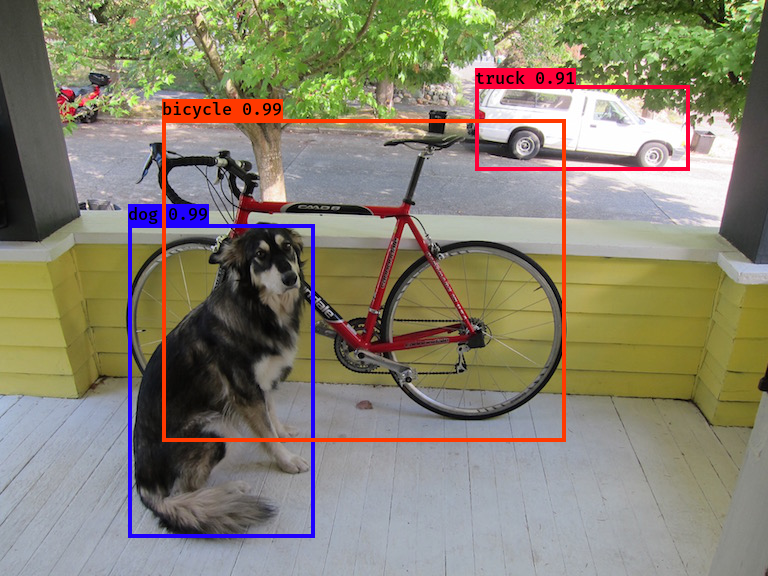

In [11]:
start = time.time()
results = yolo.pure_detect_image(image)
end = time.time()

yolo_r_image = yolo.detect_image(image)
yolo_r_image

In [12]:
print( 'Single inference took: %.3fs' % (end-start) )
fps = 1 / (end-start)
print( 'fps: %.3f' % (fps) )

time_eplased = []
for i in range(100):
  start = time.time()
  results = yolo.pure_detect_image(image)
  end = time.time()
  time_eplased.append(end-start)

avg_fps = 1/np.mean(time_eplased)
print( 'avg fps: %.3f' % avg_fps )

Single inference took: 4.437s
fps: 0.225
avg fps: 19.538


# Tiny Yolo V3 物件偵測

## 下載 Tiny Yolo V3 的網路權重，且把權重轉換為 Keras 能夠讀取的格式

In [13]:
tiny_yolo_model_path = 'model_data/yolov3-tiny.h5'
tiny_yolo_anchor_file = 'model_data/tiny_yolo_anchors.txt'

if not os.path.exists(tiny_yolo_model_path):
  print( "yolov3-tiny weights doesn't exist, downloading..." )
  os.system( 'wget https://pjreddie.com/media/files/yolov3-tiny.weights' )
  print( 'Converting yolov3-tiny.weights to yolov3-tiny.h5...' )
  os.system( 'python convert.py yolov3-tiny.cfg yolov3-tiny.weights %s' % tiny_yolo_model_path)
  if os.path.exists(tiny_yolo_model_path):
    print( 'Done!' )
  else:
    print( "Strange, model doesn't exist, pleace check" )

## 模型初始化

In [14]:
tiny_yolo = YOLO( model_path=tiny_yolo_model_path, anchors_path=tiny_yolo_anchor_file ) 


model_data/yolov3-tiny.h5 model, anchors, and classes loaded.


## Tiny Yolo V3 物件偵測

In [15]:
start = time.time()
tiny_yolo_results = tiny_yolo.pure_detect_image(image)
end = time.time()

In [16]:
print( 'single inference took: %.3fs' % (end-start))
fps = 1 / (end-start)
print( 'fps: %.3f' % (fps) )

time_eplased = []
for i in range(100):
  start = time.time()
  tiny_yolo_results = tiny_yolo.pure_detect_image(image)
  end = time.time()
  time_eplased.append(end-start)

avg_fps = 1/np.mean(time_eplased)
print( 'avg fps: %.3f' % avg_fps )

single inference took: 1.773s
fps: 0.564
avg fps: 46.016


(416, 416, 3)
Found 3 boxes for img
dog 0.68 (148, 202) (358, 499)
truck 0.68 (460, 66) (692, 180)
bicycle 0.66 (210, 157) (576, 442)
0.02925987199978408


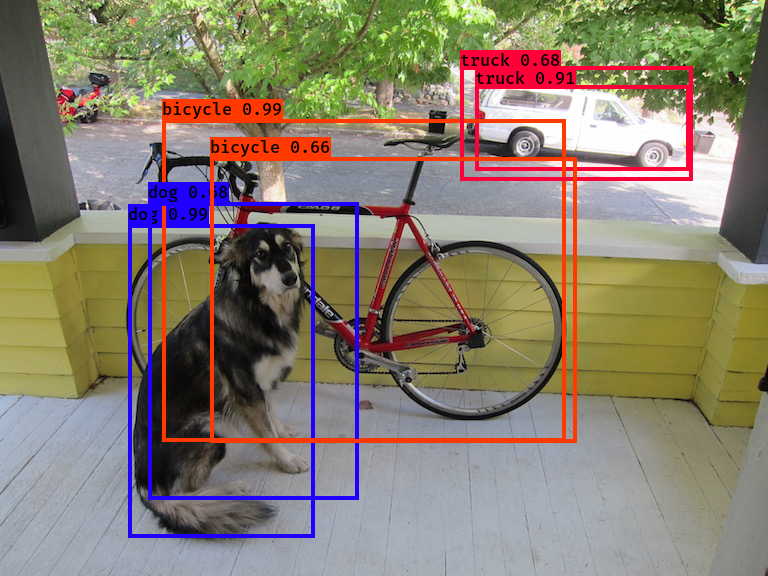

In [17]:
tiny_yolo_r_image = tiny_yolo.detect_image(image)
tiny_yolo_r_image